In [1]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import time
import eif_old as iso2
import seaborn as sb
from sklearn.ensemble import IsolationForest

In [2]:
# Create data
mean = [0, 0, 0 ]
cov = [[1, 0, 0.], [0, 0.1, 0.0], [0,0,1]]  # diagonal covariance
Nobjs = 500
np.random.seed(1)
x, y, z = np.random.multivariate_normal(mean, cov, Nobjs).T
# Add manual outlier
x[0] = 3.3
y[0] = 3.3
z[0] = 3.3
X = np.array([x,y,z]).T

In [3]:
rng = np.random.RandomState(42)

In [4]:
Ntrees = 2000
Nsamples = 256

In [5]:
# scikit learn solution
ss = time.time()
F0 = IsolationForest(n_estimators=Ntrees, behaviour='new', max_samples=Nsamples,random_state=rng, contamination=0.)
F0.fit(X)
S0 = F0.score_samples(X)*-1
ee = time.time()

In [6]:
print('{:.3f} sec, Scikit Learn'.format(ee-ss))

4.244 sec, Scikit Learn


In [7]:
ss = time.time()
F1 = iso.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0)
S1 = F1.compute_paths(X_in=X)
ee = time.time()

In [8]:
print('{:.3f} sec, EIF Cython Version'.format(ee-ss))

2.139 sec, EIF Cython Version


In [9]:
ss = time.time()
F2 = iso2.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0)
S2 = F2.compute_paths(X_in=X)
ee = time.time()

In [10]:
print('{:.3f} sec, EIF Python Version'.format(ee-ss))

47.351 sec, EIF Python Version


Text(0.5, 0, 'Scores')

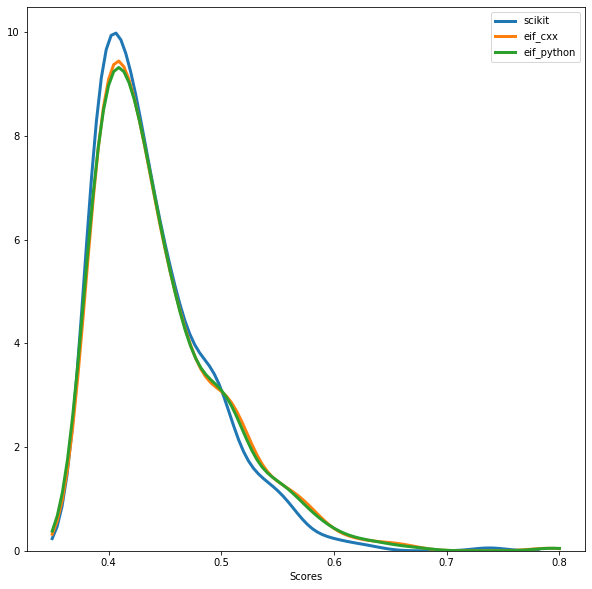

In [12]:
plt.figure(figsize=(10,10))
sb.kdeplot(S0, lw=3, label='scikit', clip=(0.35, 0.8))
sb.kdeplot(S1, lw=3, label='eif_cxx',  clip=(0.35, 0.8))
sb.kdeplot(S2, lw=3, label='eif_python',  clip=(0.35, 0.8))
plt.legend(loc=0)
plt.xlabel('Scores')